In [18]:
import tensorflow as tf
import pickle
from keras.layers import (
    Input,
    Dense,
    Input,
    Dense,
    Conv1D,
    Flatten, 
    Embedding,    
    Dropout, 
    Conv1D,
    MaxPooling1D,
    Bidirectional,
    LSTM)
from keras import Model
import keras
%run constants.py
NUM_EPOCHS = 30 # Override

In [2]:
#Dataset Prep
with open(X_TRAIN_INPUT_SAVE_FILE_VEC_SINGLE_TIMESTEP, "rb") as f:
        x_train = pickle.load(f)
with open(Y_TRAIN_INPUT_SAVE_FILE, "rb") as f:
        y_train = pickle.load(f)

with open(X_VAL_INPUT_SAVE_FILE_VEC_SINGLE_TIMESTEP, "rb") as f:
        x_val = pickle.load(f)
with open(Y_VAL_INPUT_SAVE_FILE, "rb") as f:
        y_val = pickle.load(f)

with open(X_TEST_INPUT_SAVE_FILE_VEC_SINGLE_TIMESTEP, "rb") as f:
        x_test = pickle.load(f)
with open(Y_TEST_INPUT_SAVE_FILE, "rb") as f:
        y_test = pickle.load(f)
with open(EMBEDDING_MATRIX_SAVE_FILE, "rb") as f:
        embedding_matrix = pickle.load(f)
        
embedding_layer = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights = [embedding_matrix], trainable=False)

2022-07-25 21:44:33.791547: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-25 21:44:34.726607: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6215 MB memory:  -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:03:00.0, compute capability: 7.5
2022-07-25 21:44:34.727488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6414 MB memory:  -> device: 1, name: GeForce RTX 2070, pci bus id: 0000:04:00.0, compute capability: 7.5


In [3]:
import matplotlib.pyplot as plt
def plot_graph(history):
    history_dict = history.history
    print(history_dict.keys())

    acc = history_dict['binary_accuracy']
    val_acc = history_dict['val_binary_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout()

    plt.subplot(2, 1, 1)
    # r is for "solid red line"
    plt.plot(epochs, loss, 'r', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    # plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

# CNN Classifier

In [4]:

def cnn_model():

  X_indices = Input(shape=(MAX_SEQUENCE_LENGTH,))

  embeddings = embedding_layer(X_indices)

  X = Conv1D(filters=300, kernel_size=5, padding="valid")(embeddings)

  X = MaxPooling1D()(X)
  
  X = Dropout(0.6)(X)

  X = Flatten()(X)

  X = Dense(1, activation='sigmoid')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [6]:
import tensorflow_models as tfm
train_data_size =  len(x_train)
steps_per_epoch = int(train_data_size / BATCH_SIZE)
num_train_steps = steps_per_epoch * NUM_EPOCHS
warmup_steps = int(0.1 * num_train_steps)
initial_learning_rate=2e-4

linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    end_learning_rate=0,
    decay_steps=num_train_steps)

warmup_schedule = tfm.optimization.lr_schedule.LinearWarmup(
    warmup_learning_rate = 0,
    after_warmup_lr_sched = linear_decay,
    warmup_steps = warmup_steps
)

optimizer = tf.keras.optimizers.experimental.Adam(
    learning_rate = warmup_schedule)

loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()


/home/aaron/anaconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:

model = cnn_model()
adam = keras.optimizers.Adam(learning_rate = 0.0001)

model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

history = model.fit(x=x_train, y=y_train,
                                validation_data = (x_val, y_val),
                               epochs=NUM_EPOCHS)


Epoch 1/30


2022-07-25 21:44:39.436161: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-25 21:44:40.025895: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-07-25 21:44:40.541594: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7f8610018a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-07-25 21:44:40.541645: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): GeForce RTX 2070, Compute Capability 7.5
2022-07-25 21:44:40.541656: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (1): GeForce RTX 2070, Compute Capability 7.5
2022-07-25 21:44:40.548739: I tensorflow/compiler/

23/78 [=======>......................] - ETA: 0s - loss: 0.7330 - binary_accuracy: 0.5204 

2022-07-25 21:44:41.410421: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


78/78 [==============================] - 4s 8ms/step - loss: 0.7248 - binary_accuracy: 0.5245 - val_loss: 0.6951 - val_binary_accuracy: 0.5438
Epoch 2/30
78/78 [==============================] - 0s 5ms/step - loss: 0.7010 - binary_accuracy: 0.5538 - val_loss: 0.6871 - val_binary_accuracy: 0.5766
Epoch 3/30
78/78 [==============================] - 0s 6ms/step - loss: 0.6780 - binary_accuracy: 0.5838 - val_loss: 0.6740 - val_binary_accuracy: 0.5876
Epoch 4/30
78/78 [==============================] - 0s 6ms/step - loss: 0.6425 - binary_accuracy: 0.6398 - val_loss: 0.6688 - val_binary_accuracy: 0.5839
Epoch 5/30
78/78 [==============================] - 0s 5ms/step - loss: 0.5985 - binary_accuracy: 0.6807 - val_loss: 0.6655 - val_binary_accuracy: 0.6058
Epoch 6/30
78/78 [==============================] - 0s 6ms/step - loss: 0.5718 - binary_accuracy: 0.7164 - val_loss: 0.6551 - val_binary_accuracy: 0.6022
Epoch 7/30
78/78 [==============================] - 0s 5ms/step - loss: 0.5265 - binary

22/22 [==============================] - 0s 3ms/step - loss: 0.7326 - binary_accuracy: 0.6263
Loss: 0.7326154708862305
Accuracy: 0.6262773871421814
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


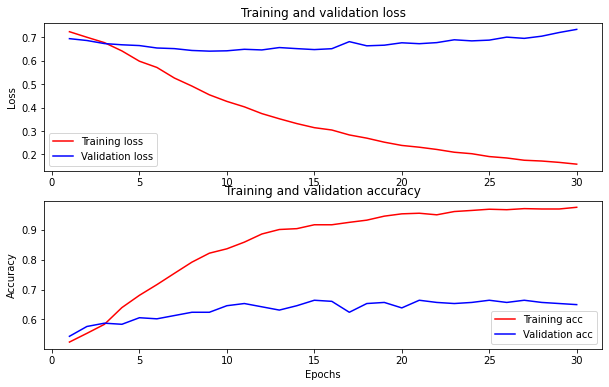

In [8]:
loss, accuracy = model.evaluate(x= x_test, y= y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
plot_graph(history)

# LSTM Classifier

In [9]:
def lstm_model():

  X_indices = Input(shape=(MAX_SEQUENCE_LENGTH,))

  embeddings = embedding_layer(X_indices)

  X = LSTM(128)(embeddings)
  
  X = Dropout(0.6)(X)

  X = Dense(1, activation='sigmoid')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [10]:
model = lstm_model()
optimizer = tf.keras.optimizers.experimental.Adam(
    learning_rate = warmup_schedule)

loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()
adam = keras.optimizers.Adam(learning_rate = 0.0001)

model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

history = model.fit(x=x_train, y=y_train,
                                validation_data = (x_val, y_val),
                               epochs=NUM_EPOCHS)


Epoch 1/30


2022-07-25 21:44:57.357420: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-07-25 21:44:57.681264: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-07-25 21:44:57.886511: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update

78/78 [==============================] - 4s 24ms/step - loss: 0.6930 - binary_accuracy: 0.5566 - val_loss: 0.6920 - val_binary_accuracy: 0.6058
Epoch 2/30
78/78 [==============================] - 1s 19ms/step - loss: 0.6937 - binary_accuracy: 0.5582 - val_loss: 0.6907 - val_binary_accuracy: 0.6022
Epoch 3/30
78/78 [==============================] - 1s 19ms/step - loss: 0.6904 - binary_accuracy: 0.5680 - val_loss: 0.6874 - val_binary_accuracy: 0.6095
Epoch 4/30
78/78 [==============================] - 1s 18ms/step - loss: 0.6860 - binary_accuracy: 0.5757 - val_loss: 0.6835 - val_binary_accuracy: 0.6095
Epoch 5/30
78/78 [==============================] - 1s 17ms/step - loss: 0.6866 - binary_accuracy: 0.5708 - val_loss: 0.6792 - val_binary_accuracy: 0.6095
Epoch 6/30
78/78 [==============================] - 1s 19ms/step - loss: 0.6816 - binary_accuracy: 0.5773 - val_loss: 0.6703 - val_binary_accuracy: 0.6095
Epoch 7/30
78/78 [==============================] - 1s 19ms/step - loss: 0.6793 -

22/22 [==============================] - 0s 8ms/step - loss: 0.6465 - binary_accuracy: 0.6365
Loss: 0.646471381187439
Accuracy: 0.636496365070343
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


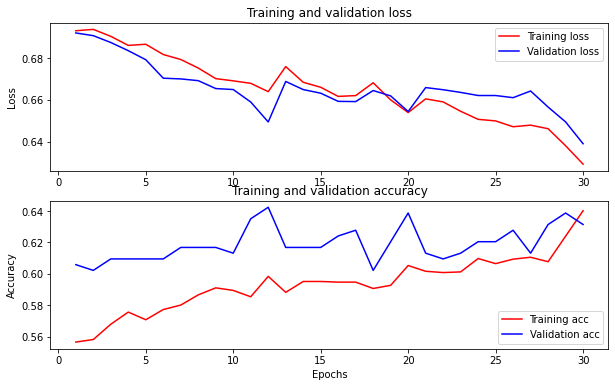

In [11]:
loss, accuracy = model.evaluate(x= x_test, y= y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
plot_graph(history)

# Stacked LSTM Classifier

In [13]:
def stacked_lstm_model():

  X_indices = Input(shape=(MAX_SEQUENCE_LENGTH,))

  embeddings = embedding_layer(X_indices)

  X = LSTM(128, return_sequences=True)(embeddings)

  X = Dropout(0.6)(X)

  X = LSTM(128, return_sequences=True)(X)

  X = Dropout(0.6)(X)

  X = LSTM(128)(X)

  X = Dense(1, activation='sigmoid')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [14]:
model = stacked_lstm_model()
optimizer = tf.keras.optimizers.experimental.Adam(
    learning_rate = warmup_schedule)

loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()
adam = keras.optimizers.Adam(learning_rate = 0.0001)

model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

history = model.fit(x=x_train, y=y_train,
                                validation_data = (x_val, y_val),
                               epochs=NUM_EPOCHS)

Epoch 1/30
78/78 [==============================] - 9s 56ms/step - loss: 0.6925 - binary_accuracy: 0.5590 - val_loss: 0.6917 - val_binary_accuracy: 0.5985
Epoch 2/30
78/78 [==============================] - 4s 47ms/step - loss: 0.6901 - binary_accuracy: 0.5704 - val_loss: 0.6866 - val_binary_accuracy: 0.6022
Epoch 3/30
78/78 [==============================] - 4s 48ms/step - loss: 0.6853 - binary_accuracy: 0.5789 - val_loss: 0.6789 - val_binary_accuracy: 0.6058
Epoch 4/30
78/78 [==============================] - 4s 46ms/step - loss: 0.6816 - binary_accuracy: 0.5720 - val_loss: 0.6726 - val_binary_accuracy: 0.5985
Epoch 5/30
78/78 [==============================] - 4s 47ms/step - loss: 0.6765 - binary_accuracy: 0.5797 - val_loss: 0.6780 - val_binary_accuracy: 0.6022
Epoch 6/30
78/78 [==============================] - 4s 47ms/step - loss: 0.6734 - binary_accuracy: 0.5886 - val_loss: 0.6838 - val_binary_accuracy: 0.6204
Epoch 7/30
78/78 [==============================] - 4s 47ms/step - los

22/22 [==============================] - 0s 20ms/step - loss: 0.7077 - binary_accuracy: 0.6715
Loss: 0.7077436447143555
Accuracy: 0.6715328693389893
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


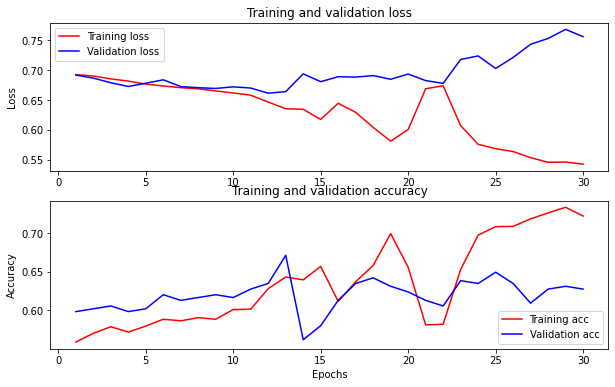

In [15]:
loss, accuracy = model.evaluate(x= x_test, y= y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
plot_graph(history)

# Bidirectional LSTM Classifier

In [16]:
def bi_lstm_model():

  X_indices = Input(shape=(MAX_SEQUENCE_LENGTH,))

  embeddings = embedding_layer(X_indices)

  X = Bidirectional(LSTM(128))(embeddings)
  
  X = Dropout(0.6)(X)

  X = Dense(1, activation='sigmoid')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [19]:
model = bi_lstm_model()
optimizer = tf.keras.optimizers.experimental.Adam(
    learning_rate = warmup_schedule)

loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()
adam = keras.optimizers.Adam(learning_rate = 0.0001)

model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

history = model.fit(x=x_train, y=y_train,
                                validation_data = (x_val, y_val),
                               epochs=NUM_EPOCHS)

Epoch 1/30


2022-07-25 21:48:46.650288: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


78/78 [==============================] - 6s 41ms/step - loss: 0.6948 - binary_accuracy: 0.5298 - val_loss: 0.6807 - val_binary_accuracy: 0.5766
Epoch 2/30
78/78 [==============================] - 2s 32ms/step - loss: 0.6939 - binary_accuracy: 0.5497 - val_loss: 0.6736 - val_binary_accuracy: 0.5876
Epoch 3/30
78/78 [==============================] - 2s 31ms/step - loss: 0.6854 - binary_accuracy: 0.5582 - val_loss: 0.6669 - val_binary_accuracy: 0.6022
Epoch 4/30
78/78 [==============================] - 2s 32ms/step - loss: 0.6794 - binary_accuracy: 0.5639 - val_loss: 0.6561 - val_binary_accuracy: 0.6058
Epoch 5/30
78/78 [==============================] - 2s 32ms/step - loss: 0.6701 - binary_accuracy: 0.5736 - val_loss: 0.6546 - val_binary_accuracy: 0.6314
Epoch 6/30
78/78 [==============================] - 2s 32ms/step - loss: 0.6580 - binary_accuracy: 0.6004 - val_loss: 0.6509 - val_binary_accuracy: 0.6314
Epoch 7/30
78/78 [==============================] - 3s 32ms/step - loss: 0.6533 -

22/22 [==============================] - 0s 14ms/step - loss: 0.6823 - binary_accuracy: 0.6423
Loss: 0.6823436617851257
Accuracy: 0.6423357725143433
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


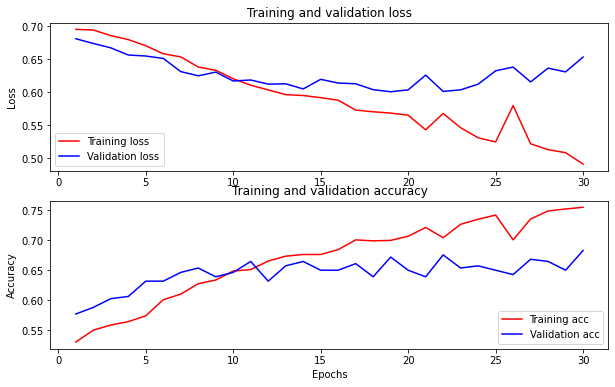

In [20]:
loss, accuracy = model.evaluate(x= x_test, y= y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
plot_graph(history)

# Stacked Bidirectional LSTM

In [21]:
def stacked_bi_lstm_model():

  X_indices = Input(shape=(MAX_SEQUENCE_LENGTH,))

  embeddings = embedding_layer(X_indices)

  X = Bidirectional(LSTM(128, return_sequences=True))(embeddings)

  X = Dropout(0.6)(X)

  X = Bidirectional(LSTM(128, return_sequences=True))(X)

  X = Dropout(0.6)(X)

  X = Bidirectional(LSTM(128))(X)

  X = Dense(1, activation='sigmoid')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [22]:
model = stacked_bi_lstm_model()
optimizer = tf.keras.optimizers.experimental.Adam(
    learning_rate = warmup_schedule)

loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()
adam = keras.optimizers.Adam(learning_rate = 0.0001)

model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

history = model.fit(x=x_train, y=y_train,
                                validation_data = (x_val, y_val),
                               epochs=NUM_EPOCHS)

Epoch 1/30
78/78 [==============================] - 17s 106ms/step - loss: 0.6891 - binary_accuracy: 0.5456 - val_loss: 0.6733 - val_binary_accuracy: 0.6131
Epoch 2/30
78/78 [==============================] - 7s 86ms/step - loss: 0.6802 - binary_accuracy: 0.5627 - val_loss: 0.6606 - val_binary_accuracy: 0.6058
Epoch 3/30
78/78 [==============================] - 7s 85ms/step - loss: 0.6691 - binary_accuracy: 0.5809 - val_loss: 0.6481 - val_binary_accuracy: 0.6058
Epoch 4/30
78/78 [==============================] - 7s 84ms/step - loss: 0.6528 - binary_accuracy: 0.6207 - val_loss: 0.6285 - val_binary_accuracy: 0.6168
Epoch 5/30
78/78 [==============================] - 7s 85ms/step - loss: 0.6433 - binary_accuracy: 0.6162 - val_loss: 0.6565 - val_binary_accuracy: 0.6095
Epoch 6/30
78/78 [==============================] - 7s 84ms/step - loss: 0.6328 - binary_accuracy: 0.6410 - val_loss: 0.6289 - val_binary_accuracy: 0.6314
Epoch 7/30
78/78 [==============================] - 6s 83ms/step - l

22/22 [==============================] - 1s 34ms/step - loss: 1.0479 - binary_accuracy: 0.6146
Loss: 1.047944188117981
Accuracy: 0.6145985126495361
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


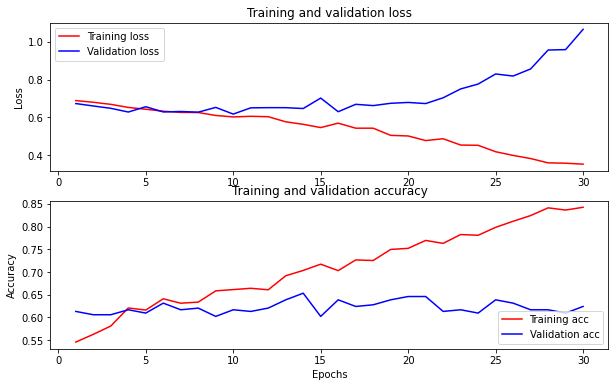

: 

In [23]:
loss, accuracy = model.evaluate(x= x_test, y= y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
plot_graph(history)